In [3]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt

# import h5py to read se h5 files properly?
import h5py

# for plotting consistently with abu_profile
from nugridpy import utils as u

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
# get mesa and pp star
star = ms.star_log(mass=2.0,Z=0.02)
star_pp = mp.se(mass=2.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Searching files, please wait.......
Reading preprocessor files
File search complete.


In [1]:
# define a function to use an iso_massf, isotope list and grab those data arrays
def find_iso(iso_massf,isotope_list,species_find):
    
    # isotope list contains all isotopes and species_fin contains what I'm looking for
    # find indices corresponding to species list
    iso_index = []
    for i in range(len(species_find)):
        for p in range(len(isotope_list)):
            if species_find[i] == isotope_list[p]:
                iso_index.append(p)
                break
    
    # create a list which will slice iso_massf
    iso_out = []
    for i in range(len(iso_index)):
        iso_out.append(iso_massf[:,iso_index[i]])
    
    # return iso_out
    return iso_out

# define function to get a 'quantity' for an h5py file of a given cycle/model number
def h5_quantity(h5_file,cycle,quantity):
    
    # quantity is a string which is the data I am looking for
    # cycle string format
    cycle_string = 'cycle00000' + str(int(cycle))
    data = h5_file[cycle_string]['SE_DATASET'][quantity]
    
    return data

# place in an array of mass quantities, look for [mass_find] and return mass_index
def find_mass_index(mass,mass_find):
    
    # mass is a singular mass array, need to find mass_find, may be multiple
    mass_index = []
    for i in range(len(mass_find)):
        mass_index.append(int(np.argmin(abs(mass - mass_find[i]))))
        
    # return the list
    return mass_index

# function to find a specific models schwarzschild boundaries in indices
def mass_bounds(star,model,mass):
    
    # WORKING WITH MODEL #, NEED TO USE PYTHON SLICING THOUGH
    # get the boundaries of mass for the convection zone
    star_mass = star.get('star_mass')[model-1]
    mix_bot = star.get('mx2_bot')[model-1] * star_mass
    mix_top = star.get('mx2_top')[model-1] * star_mass
    
    # find indices
    schwarz = []
    schwarz.append(int(np.argmin(abs(mass - mix_bot))))
    schwarz.append(int(np.argmin(abs(mass - mix_top))))
    
    # return
    return schwarz

    # function to find the maximum extent of convection zone as well as the average extent
def avg_mass_bounds(star,model_range):
    # just need the star objects, and the model range that the convection zone is contained in

    # get the mass ranges of convection boundary
    star_mass = star.get('star_mass')[model_range[0]:model_range[1]]
    mix_low = star.get('mx2_bot')[model_range[0]:model_range[1]]
    mix_high = star.get('mx2_top')[model_range[0]:model_range[1]]
    
    # find where they are zero or not
    convection_bounds = []
    for i in range(len(star_mass) - 1):
        
        # make sure that there is convection and that the next element doesnt stop
        if mix_low[i] >= 1e-9 and mix_low[i+1] >= 1e-9:
            convection_bounds.append(i)
            
    # slice the arrays to the appropriate size
    star_mass = star_mass[convection_bounds[0]:(convection_bounds[-1] + 1)]
    mix_low = mix_low[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    mix_high = mix_high[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    
    # make sure that if there
    
    # return the max convection bounds as well as average AND new model range
    max_bounds = [min(mix_low),max(mix_high)]
    avg_bounds = [np.mean(mix_low),np.mean(mix_high)]
    model_range = [model_range[0] + convection_bounds[0], model_range[0] + convection_bounds[-1]]
    
    return max_bounds, avg_bounds, model_range

In [5]:
# read in the data using nugridse
path0 = '/user/ast501/dstephens/mppnp/diffusion_mesa/mppnp_subtime_0/H5_out/'
path100 = '/user/ast501/dstephens/mppnp/diffusion_changes/h5_Jones_S100/mppnp_subtime_0/H5_out/'

star0_pp = mp.se(path0,rewrite=True)
star100_pp = mp.se(path100,rewrite=True)

Searching files, please wait.......
Writing preprocessor files
M2.00Z0.020.0053001.out.h5
M2.00Z0.020.0053501.out.h5
File search complete.
Searching files, please wait.......
Writing preprocessor files
M2.00Z0.020.0053001.out.h5
M2.00Z0.020.0053621.out.h5
M2.00Z0.020.0053501.out.h5
File search complete.


In [6]:
# get the iso_massf for each and look at species list
species = ['Neutron-1','Ne-22','Mg-25','Zr-94','Zr-96','I-127','I-128']

# get the isotope list and iso_massf data for each
isotopes = star0_pp.se.isotopes
model = 53750

iso_massf0 = find_iso(star0_pp.get(model,'iso_massf'),isotopes,species)
iso_massf100 = find_iso(star100_pp.get(model,'iso_massf'),isotopes,species)
mass = star0_pp.get(model,'mass')

# take the ratio of the two 
iso_ratio = []
for i in range(len(iso_massf0)):
    iso_ratio.append(np.log10(iso_massf100[i] / iso_massf0[i]))

 reading ['mass']...100%.100%

In [7]:
# get the average convection boundaries
model_range = [53000,53900]
max_bounds, avg_bounds, model_range = avg_mass_bounds(star,model_range)
schwarz = mass_bounds(star,model,mass)

<IPython.core.display.Javascript object>


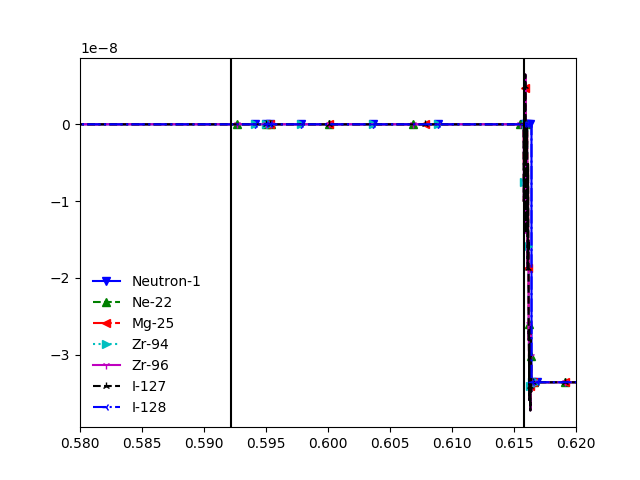

In [8]:
# make the plot of the iso_ratio
plt.figure(1)

# plot as a function of mass
for i in range(len(iso_ratio)):
    plt.plot(mass,iso_ratio[i],u.linestyle(i)[0],label=species[i],
             markevery=u.linestyle(i)[1]*20)

# plot the max and min bounds
# plt.axvline(mass[schwarz[0]],color='k',linestyle='-')
# plt.axvline(mass[schwarz[1]],color='k',linestyle='-')
plt.axvline(max_bounds[0],color='k',linestyle='-')
plt.axvline(max_bounds[1],color='k',linestyle='-')

# make the bounds reasonable
plt.xlim([0.58,0.62])

# legend
plt.legend().draw_frame(False)

In [9]:
# read in the data files between the two
h5_100 = h5py.File(path100 + 'M2.00Z0.020.0053501.out.h5')
h5_0 = h5py.File(path0 + 'M2.00Z0.020.0053501.out.h5')

In [10]:
# get the iso_massf
h5_massf100 = h5_quantity(h5_100,model,'iso_massf')
h5_massf0 = h5_quantity(h5_0,model,'iso_massf')
h5_mass = h5_quantity(h5_0,model,'mass')

In [11]:
# using species, grab the arrays wanted
iso_massf0 = find_iso(h5_massf0,isotopes,species)
iso_massf100 = find_iso(h5_massf100,isotopes,species)

h5_iso_ratio = []
for i in range(len(species)):
    h5_iso_ratio.append(np.log10(iso_massf100[i] / iso_massf0[i]))

<IPython.core.display.Javascript object>


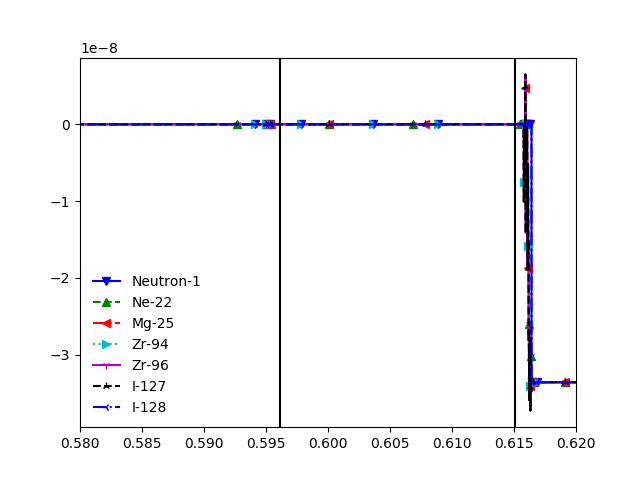

In [12]:
# make the plot of the iso_ratio
plt.figure(3)

# plot as a function of mass
for i in range(len(h5_iso_ratio)):
    plt.plot(h5_mass,h5_iso_ratio[i],u.linestyle(i)[0],label=species[i],
             markevery=u.linestyle(i)[1]*20)

# plot the max and min bounds
plt.axvline(mass[schwarz[0]],color='k',linestyle='-')
plt.axvline(mass[schwarz[1]],color='k',linestyle='-')

# make the bounds reasonable
plt.xlim([0.58,0.62])

# legend
plt.legend().draw_frame(False)